In [1]:
#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import zipfile
import shutil
#from tensorflow.keras.applications.inception_v3 import InceptionV3

train_dir = 'split_0.2/train_dir/'
validation_dir = 'split_0.2/validation_dir/'

train_fresh_spinachs_dir = train_dir +'Fresh' #'train_dir/Fresh'
train_spinachs_n_fresh_dir = train_dir +'Not_fresh'#'train_dir/Not_fresh'
validation_fresh_spinachs_dir = validation_dir +'Fresh'#'validation_dir/Fresh'
validation_spinachs_n_fresh_dir = validation_dir +'Not_fresh'#'validation_dir/Not_fresh'

train_cat_fnames = os.listdir(train_fresh_spinachs_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_spinachs_n_fresh_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['fresh_spinach(1).jpeg', 'fresh_spinach(1).jpg', 'fresh_spinach(10).jpeg', 'fresh_spinach(10).jpg', 'fresh_spinach(11).jpeg', 'fresh_spinach(11).jpg', 'fresh_spinach(12).jpeg', 'fresh_spinach(12).jpg', 'fresh_spinach(13).jpeg', 'fresh_spinach(13).jpg']
['IMG-0467-1.jpeg', 'IMG_1334.jpeg', 'IMG_1950.jpeg', 'IMG_2413.jpeg', 'IMG_3054.jpeg', 'IMG_3882-1.jpeg', 'IMG_6465-680x510.jpeg', 'Japanese+indigo+leaves.jpeg', 'Palak-nu-shaak-steps-1_01.jpeg', 'PhotoDraw254137.jpeg']


In [2]:
print('total training fresh spinach images:', len(os.listdir(train_fresh_spinachs_dir)))
print('total training spinach not fresh images:', len(os.listdir(train_spinachs_n_fresh_dir)))
print('total validation fresh spinach images:', len(os.listdir(validation_fresh_spinachs_dir)))
print('total validation spinach not fresh images:', len(os.listdir(validation_spinachs_n_fresh_dir)))

total training fresh spinach images: 120
total training spinach not fresh images: 120
total validation fresh spinach images: 30
total validation spinach not fresh images: 30


 For both cats and dogs, i limited the size for  2000 training images and 1000 test images.

## Data Augmentation

In [3]:
#train_dir = 'train_dir_0.2/'
class_names = os.listdir(train_dir)
num_class = len(class_names)
print(class_names)
num_class

['Fresh', 'Not_fresh']


2

In [4]:
#validation_dir = 'validation_dir_0.2/'
class_names = os.listdir(validation_dir)
num_class = len(class_names)
print(class_names)
num_class

['Fresh', 'Not_fresh']


2

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator

### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
#train_datagen = ImageDataGenerator(rescale = 1./255.)
#train_datagen = ImageDataGenerator(rescale=1./255.)
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

  # Pass in the appropriate arguments to the flow_from_directory method
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      batch_size=45,
                                                      class_mode='categorical',
                                                      #class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
validation_datagen = ImageDataGenerator(rescale = 1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                                batch_size=5,
                                                                class_mode='categorical',
                                                                #class_mode='binary',
                                                                target_size=(150, 150))
  ### END CODE HERE

Found 240 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


## Adding Dropout

In [6]:
from tensorflow.keras.callbacks import Callback

#creates a custom callback class
class CustomCallback(Callback):
    """
    This callback will stop the model from training once the model reaches 95% accuracy on the training data
    """
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95:
            print('Accuracy above 95% -- Stopping Training')
            self.model.stop_training = True #stops model training

callbacks = CustomCallback()

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

In [8]:
import tensorflow as tf
def create_model():
  # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
  # USE AT LEAST 3 CONVOLUTION LAYERS

  ### START CODE HERE

  model = tf.keras.models.Sequential([ 
      # Note the input shape is the desired size of the image 150x150 with 3 bytes color
      #tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(150, 150, 3)),
      
      tf.keras.layers.MaxPooling2D(2,2),
      
      #tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
      
      tf.keras.layers.MaxPooling2D(2,2), 
      
      #tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
      
      tf.keras.layers.MaxPooling2D(2,2),
      # Flatten the results to feed into a DNN
      tf.keras.layers.Flatten(), 
      # 512 neuron hidden layer
      tf.keras.layers.Dense(512, activation='relu'), 
      # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('fres') and 1 for the other ('not fresh')
      tf.keras.layers.Dense(2, activation='sigmoid'),
  ])

  
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                #optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='binary_crossentropy',
                #loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
    
    
  ### END CODE HERE

  return model

In [9]:
import tensorflow as tf

def create_model1():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'],
                 )
    
    return model

## Training

In [10]:
model = create_model1()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [11]:
history = model.fit(train_generator,
                    epochs=50,
                    verbose=1,
                    #callbacks=[callbacks],
                    validation_data=validation_generator
                   )

Epoch 1/50
6/6 [==============================] - 11s 2s/step - loss: 0.7077 - accuracy: 0.5000 - val_loss: 0.6846 - val_accuracy: 0.6167
Epoch 2/50
6/6 [==============================] - 11s 2s/step - loss: 0.6858 - accuracy: 0.6417 - val_loss: 0.6765 - val_accuracy: 0.6667
Epoch 3/50
6/6 [==============================] - 11s 2s/step - loss: 0.6737 - accuracy: 0.6542 - val_loss: 0.6618 - val_accuracy: 0.5000
Epoch 4/50
6/6 [==============================] - 11s 2s/step - loss: 0.6749 - accuracy: 0.5042 - val_loss: 0.6543 - val_accuracy: 0.5000
Epoch 5/50
6/6 [==============================] - 11s 2s/step - loss: 0.6497 - accuracy: 0.5917 - val_loss: 0.6416 - val_accuracy: 0.7000
Epoch 6/50
6/6 [==============================] - 11s 2s/step - loss: 0.6344 - accuracy: 0.5833 - val_loss: 0.6254 - val_accuracy: 0.5833
Epoch 7/50
6/6 [==============================] - 11s 2s/step - loss: 0.6138 - accuracy: 0.6292 - val_loss: 0.5884 - val_accuracy: 0.7333
Epoch 8/50
6/6 [==================

### Training and  Accuracy  visualisation for cnn

Text(0.5, 1.0, 'Training and validation loss')

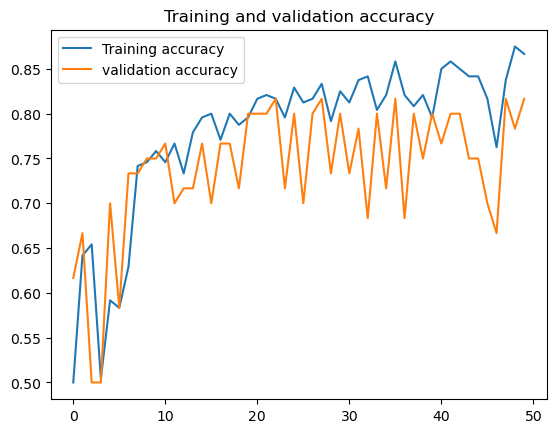

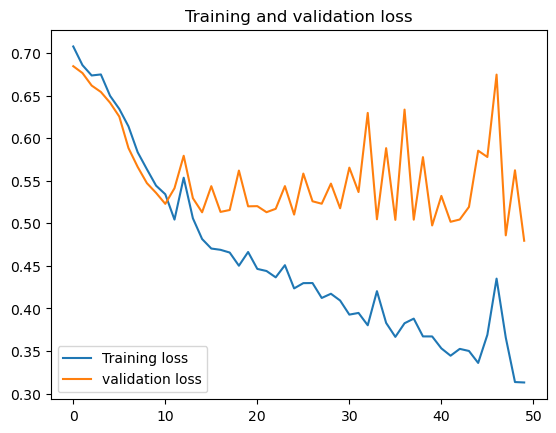

In [13]:
#%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc,label="Training accuracy")
plt.plot(epochs, val_acc,label="validation accuracy")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss,label="Training loss")
plt.plot(epochs, val_loss,label="validation loss")
plt.legend()
plt.title('Training and validation loss')

In [51]:
evaluate = model.evaluate(validation_generator)
acc = evaluate[1]
model.evaluate(train_generator)

6/6 [==============================] - 9s 2s/step - loss: 0.3126 - accuracy: 0.8458


[0.31258493661880493, 0.8458333611488342]

In [50]:
from keras.models import Sequential, save_model, load_model
save_model(model, 'Model/acc' +str(acc)+ '_0.2_ideal_detect_freshness_spinach.h5')
#model = load_model('acc0.8333333134651184_0.2_ideal_detect_freshness_spinach.h5')
evaluate = model.evaluate(train_generator)

6/6 [==============================] - 9s 1s/step - loss: 0.3190 - accuracy: 0.8458


In [30]:
#prediksi
#melakukan prediksi dengan data uji
#predicted class merupakan kelas output dari algoritma
pred = model.predict(validation_generator)
predicted_class = pred.argmax(axis=-1)
predicted_class

12/12 [==============================] - 2s 147ms/step


array([1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0], dtype=int64)

In [31]:
#true class merupakan kelas sebenarnya dari data uji
true_class = validation_generator.classes
#true_class = true_class.tolist()
true_class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [18]:
def predict_one_image(test_dir):
    pred = model.predict(test_generator)
    predicted_class = pred.argmax(axis=-1)
    if(predicted_class)==0:
        print('The spinach is fresh')
    else:
        print('The spinach is not fresh')

In [46]:
#test_dir = 'Test_segar_dir/'
#test_dir = 'Test_tidak_segar_dir/'
#test_dir = 'Test_campur_dir/'
test_dir = 'test_1'
test_datagen = ImageDataGenerator(rescale = 1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
test_generator = validation_datagen.flow_from_directory(directory=test_dir,
                                                                batch_size=5,
                                                                class_mode='categorical',
                                                                target_size=(150, 150))

Found 1 images belonging to 1 classes.


In [47]:
#prediksi
#melakukan prediksi dengan data uji
#predicted class merupakan kelas output dari algoritma
pred = model.predict(test_generator)
predicted_class = pred.argmax(axis=-1)
predicted_class

predict_one_image(test_generator)

1/1 [==============================] - 0s 90ms/step
The spinach is not fresh


In [32]:
#evaluasi
from sklearn.metrics import classification_report
print(classification_report(true_class, predicted_class))

              precision    recall  f1-score   support

           0       0.52      0.53      0.52        30
           1       0.52      0.50      0.51        30

    accuracy                           0.52        60
   macro avg       0.52      0.52      0.52        60
weighted avg       0.52      0.52      0.52        60



In [41]:
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
import numpy as np
from keras.models import Sequential, save_model, load_model
#save_model(model, 'Model/acc' +str(acc)+ '_0.2_ideal_detect_freshn

# Model in Production
# Using google colab file system
#uploaded = files.upload()

#model = load_model('acc0.8833333253860474_0.2_(1)_of_detect_freshness_spinach.h5')
  # Predicting Images
path = "test_1/only/spinach_not-fresh (8).jpeg" 
path0 = 'test_0/only/fresh_spinach(3).jpg'
img = image.load_img(path0, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
max = np.amax(classes[0])

if (max == 0):
    print('Fresh Spinach')
else:
    print('Fresh Not spinach')

classes
    

1/1 [==============================] - 0s 48ms/step
Fresh Not spinach


array([[1., 0.]], dtype=float32)

### FCN